Found datasets (true R3): [ 774.3  887.1  987.3 1144.5 1241.2 1363.8 1463.1 1673.7 1775.2 1885.6
 2003.  2463.  2697.1 2908.2 3231.1]
Target 774.3 -> selected file 774-3.txt (true R3 = 774.3)
Target 887.1 -> selected file 887-1.txt (true R3 = 887.1)
Target 987.3 -> selected file 987-3.txt (true R3 = 987.3)
Target 1144.5 -> selected file 1144-5.txt (true R3 = 1144.5)
Target 1241.2 -> selected file 1241-2.txt (true R3 = 1241.2)
Target 1363.8 -> selected file 1363-8.txt (true R3 = 1363.8)
Target 1463.1 -> selected file 1463-1.txt (true R3 = 1463.1)
Target 1673.7 -> selected file 1673-7.txt (true R3 = 1673.7)
Target 1775.2 -> selected file 1775-2.txt (true R3 = 1775.2)
Target 1885.6 -> selected file 1885-6.txt (true R3 = 1885.6)
Target 2003.0 -> selected file 2003.txt (true R3 = 2003.0)
Target 2463.0 -> selected file 2463.txt (true R3 = 2463.0)
Target 2697.1 -> selected file 2697-1.txt (true R3 = 2697.1)
Target 2908.2 -> selected file 2908-2.txt (true R3 = 2908.2)
Target 3231.1 -> selected

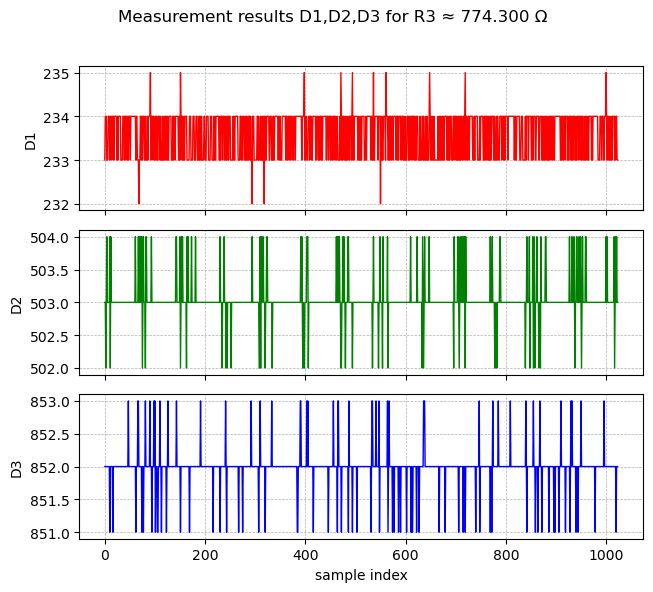

Saved timeseries_774.300.png


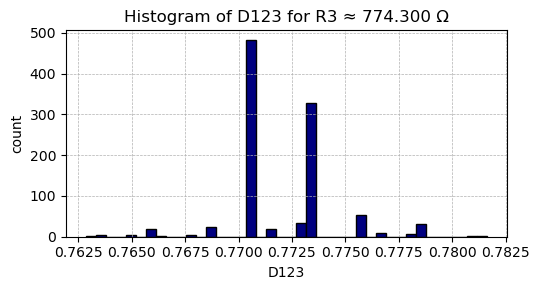

Saved hist_D123_774.300.png


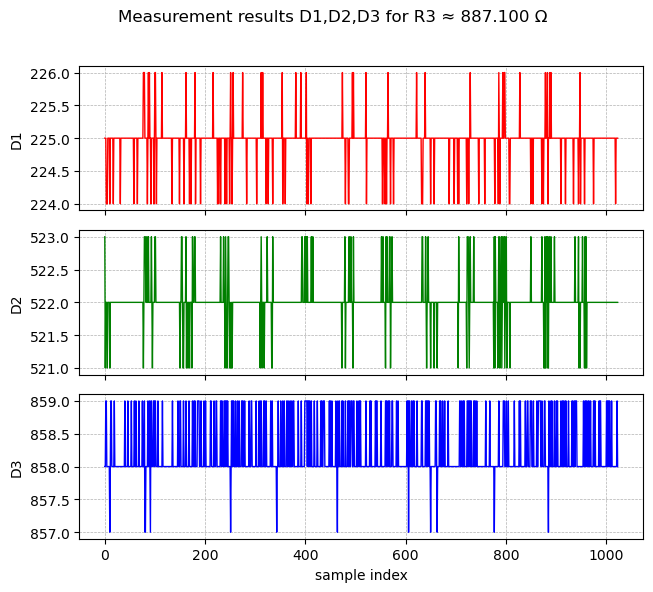

Saved timeseries_887.100.png


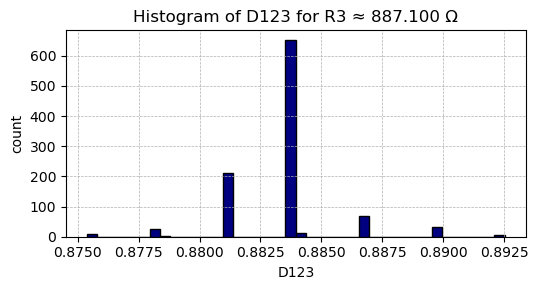

Saved hist_D123_887.100.png


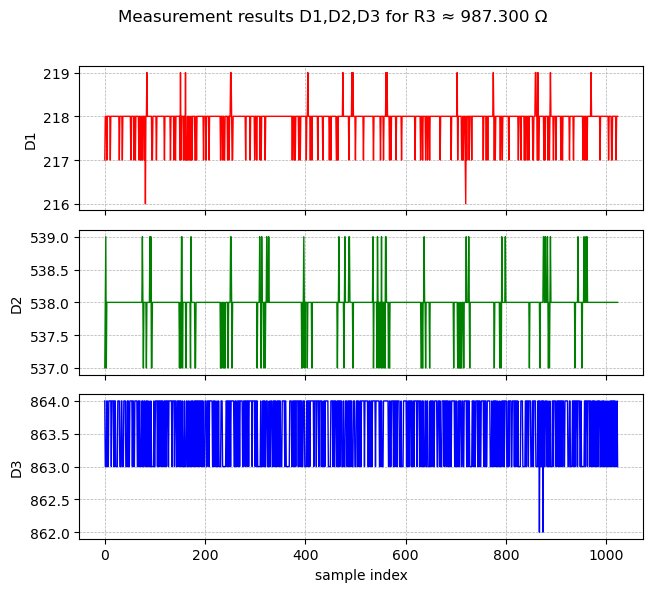

Saved timeseries_987.300.png


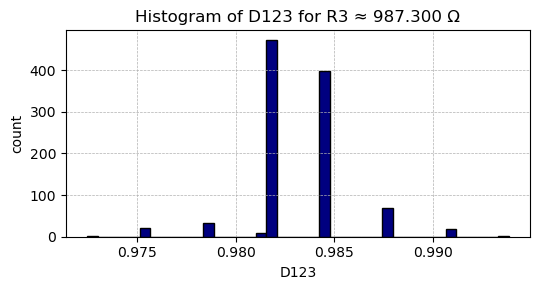

Saved hist_D123_987.300.png


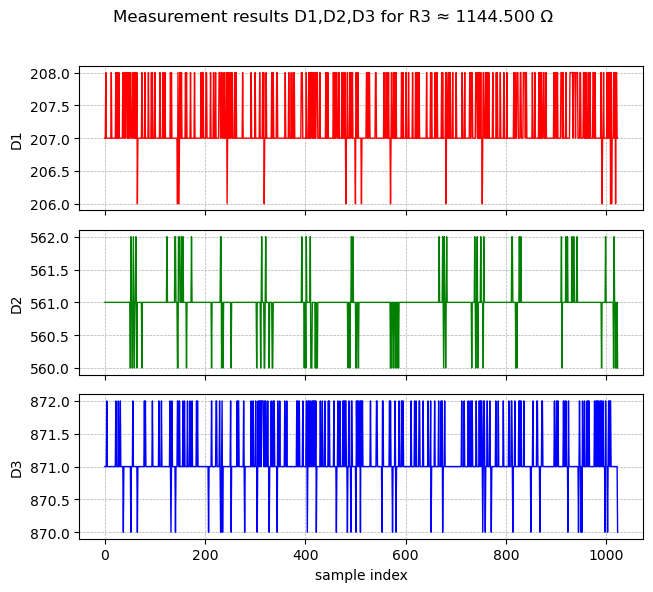

Saved timeseries_1144.500.png


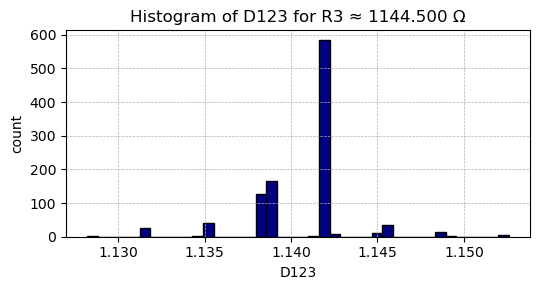

Saved hist_D123_1144.500.png


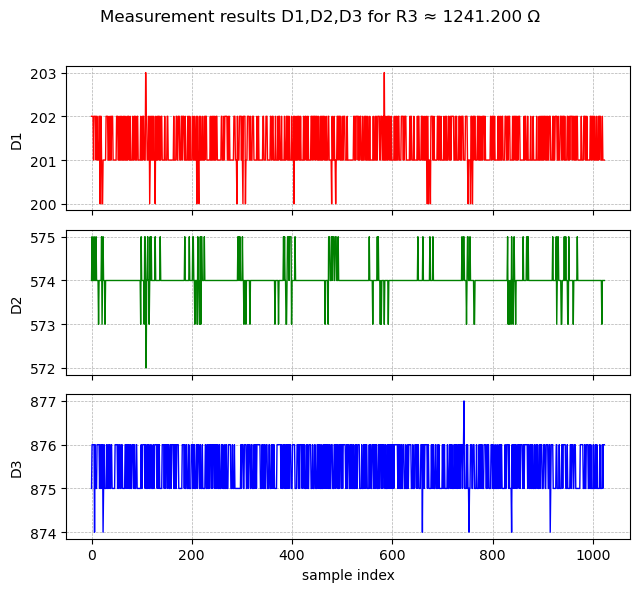

Saved timeseries_1241.200.png


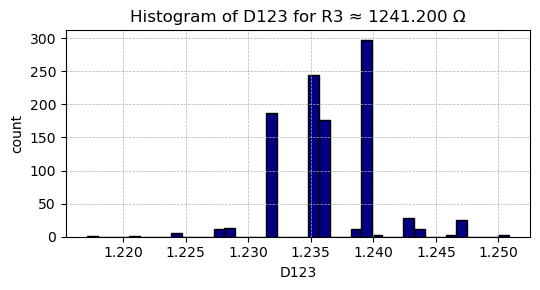

Saved hist_D123_1241.200.png


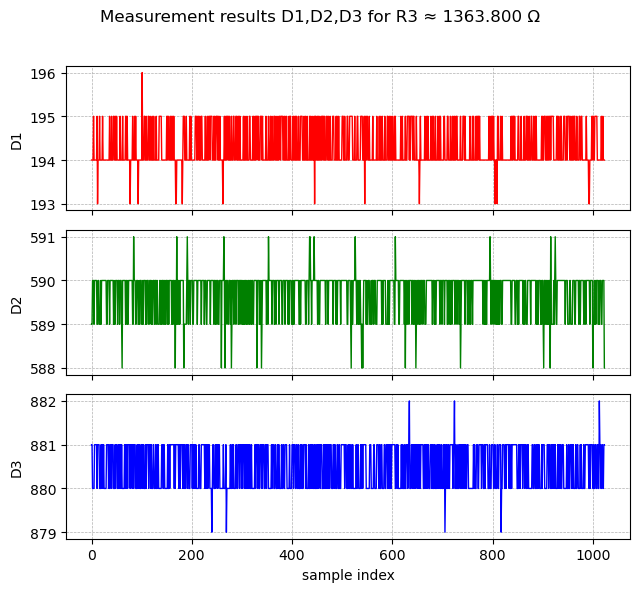

Saved timeseries_1363.800.png


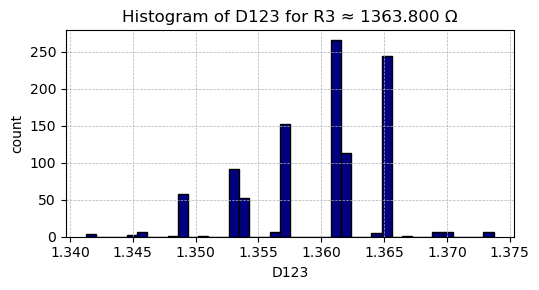

Saved hist_D123_1363.800.png


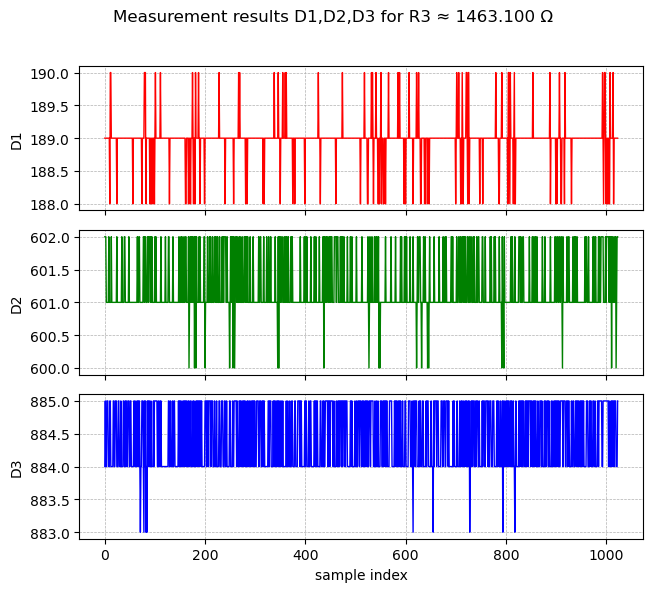

Saved timeseries_1463.100.png


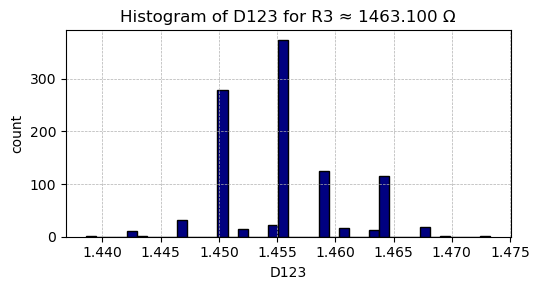

Saved hist_D123_1463.100.png


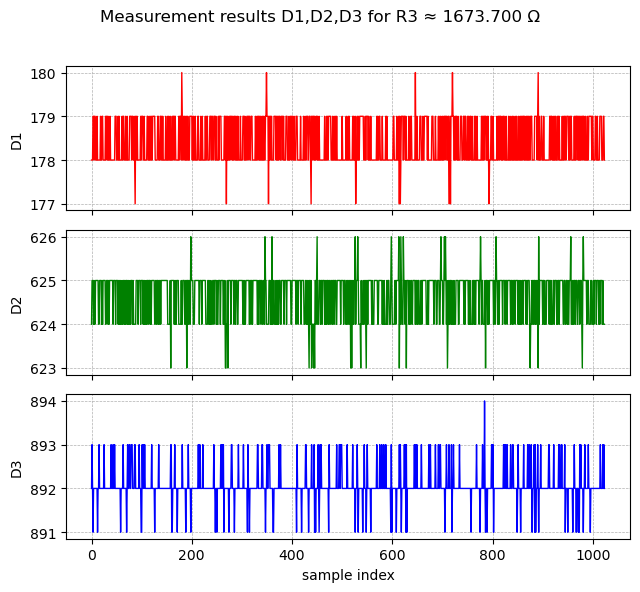

Saved timeseries_1673.700.png


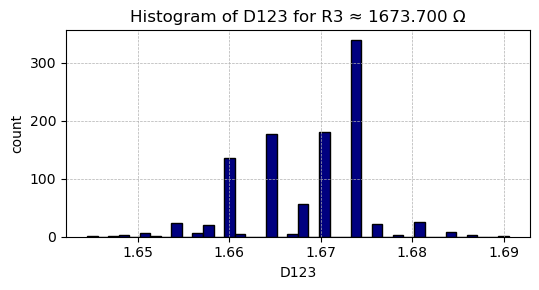

Saved hist_D123_1673.700.png


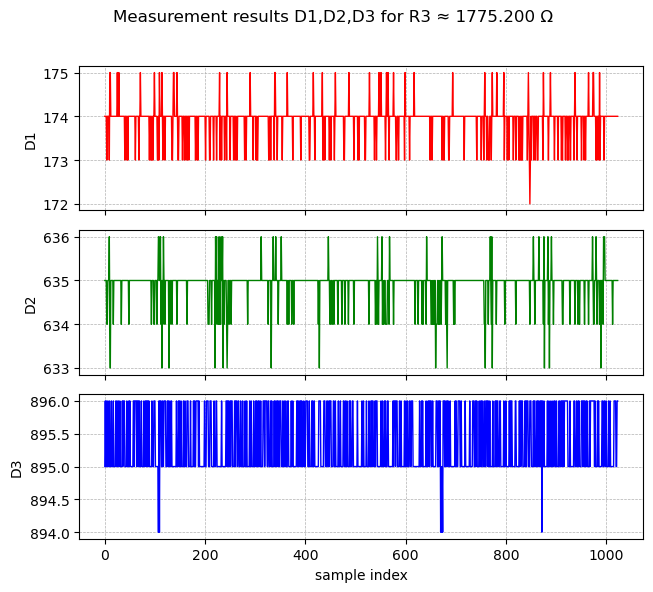

Saved timeseries_1775.200.png


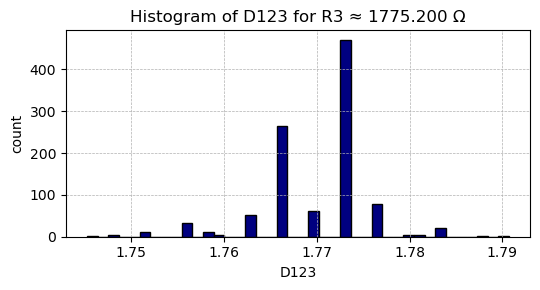

Saved hist_D123_1775.200.png


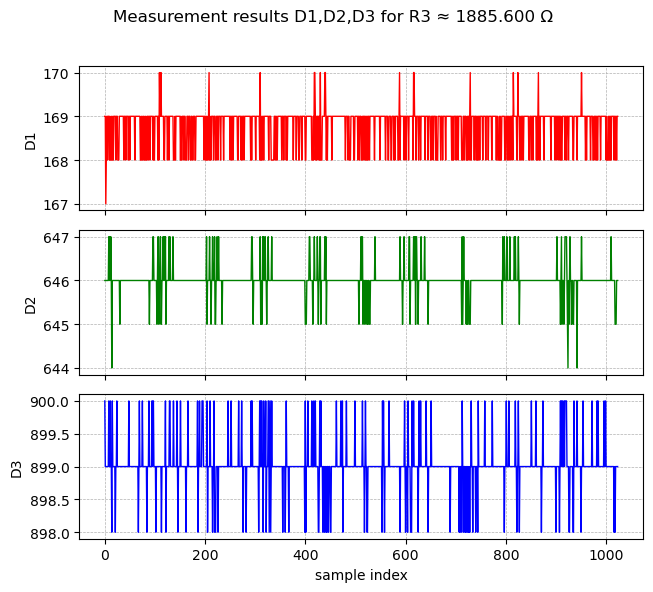

Saved timeseries_1885.600.png


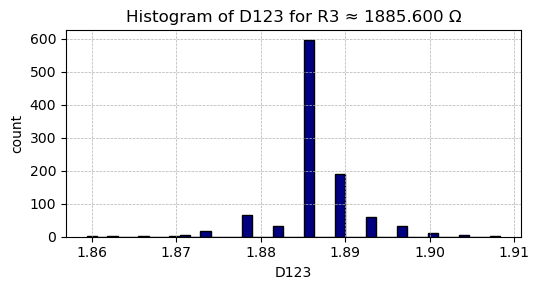

Saved hist_D123_1885.600.png


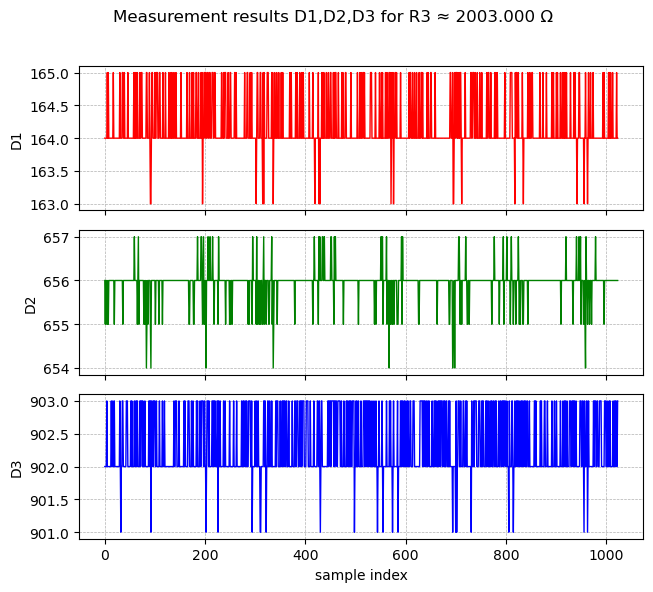

Saved timeseries_2003.000.png


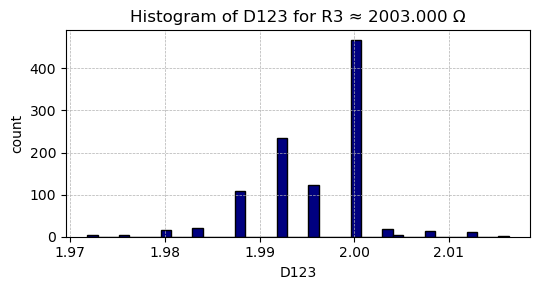

Saved hist_D123_2003.000.png


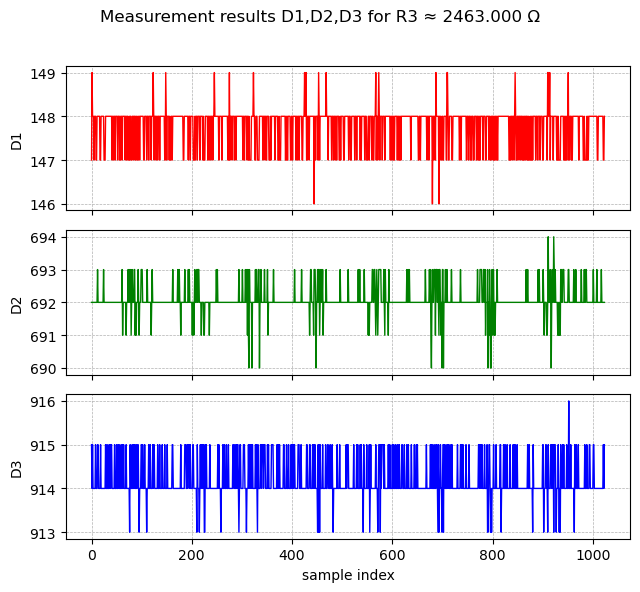

Saved timeseries_2463.000.png


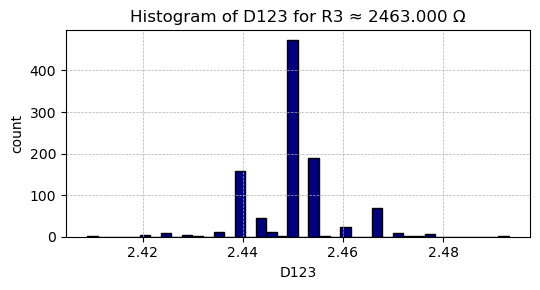

Saved hist_D123_2463.000.png


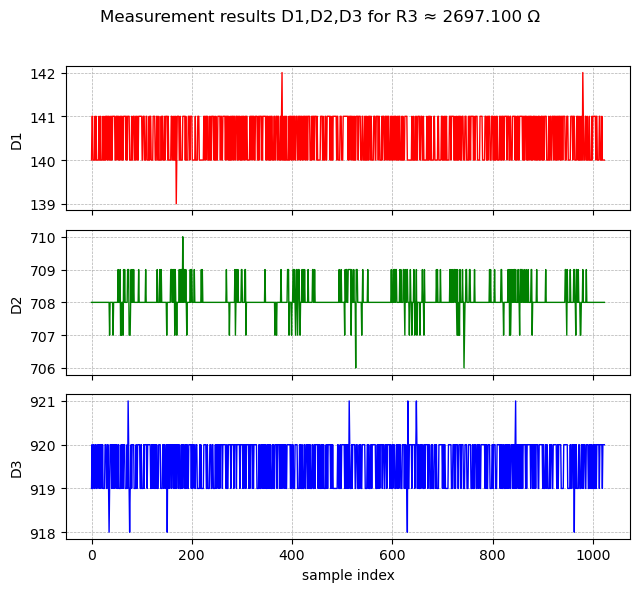

Saved timeseries_2697.100.png


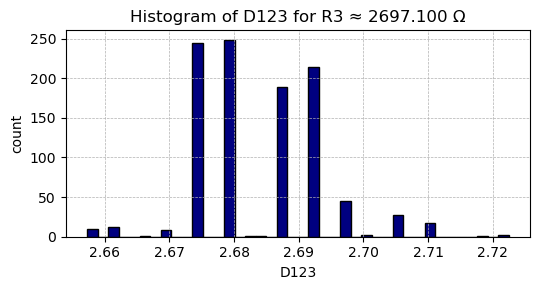

Saved hist_D123_2697.100.png


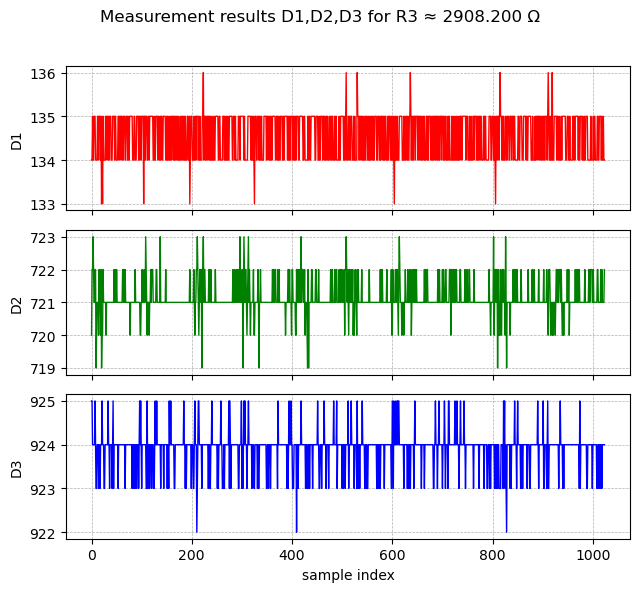

Saved timeseries_2908.200.png


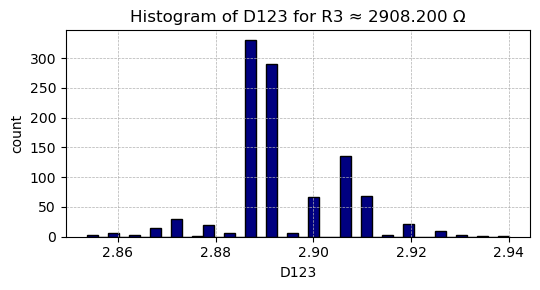

Saved hist_D123_2908.200.png


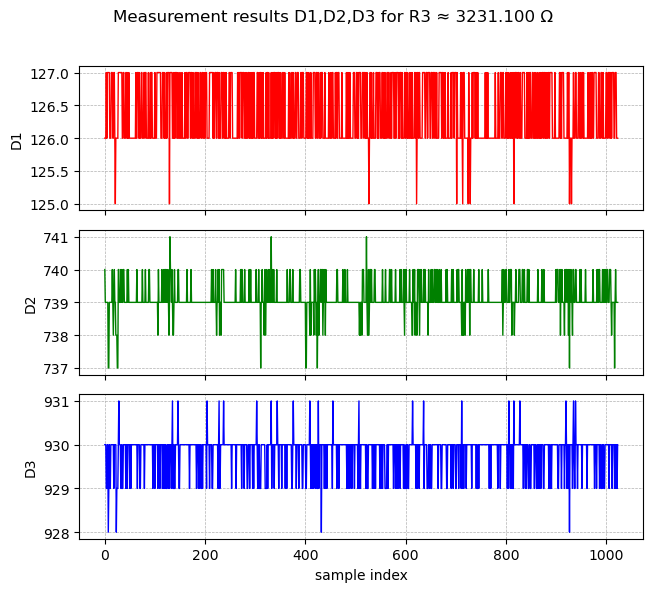

Saved timeseries_3231.100.png


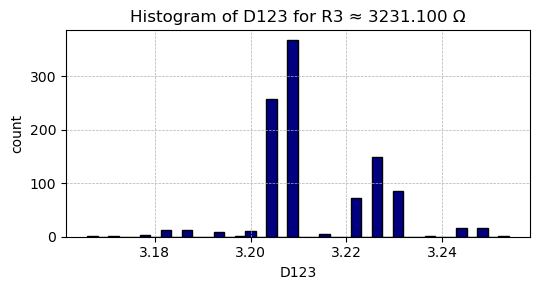

Saved hist_D123_3231.100.png
Done.


In [6]:
#!/usr/bin/env python3
"""
plot_nearest_cases.py

Find nearest available R3 dataset(s) to given target R3 values, then:
 - plot time-series of D1, D2, D3 (stacked) for first N_TIME samples
 - plot histogram of D123 for all valid samples

Usage:
  python plot_nearest_cases.py
Edit TARGETS below to choose the R3 values you want to match.
"""

import os, math
import numpy as np
import matplotlib.pyplot as plt

DATA_FOLDER = "data"   # folder with your .txt files
TARGETS = [774.3,  887.1 , 987.3 ,1144.5, 1241.2 ,1363.8, 1463.1, 1673.7, 1775.2, 1885.6,
 2003. , 2463. , 2697.1, 2908.2 ,3231.1]   # default targets from the paper; change as needed
N_TIME = 1024          # number of samples to plot on time-series (like paper)

# ---------- helper: load file format ----------
def parse_file(path):
    d1=[]; d2=[]; d3=[]
    with open(path,'r',errors='ignore') as fh:
        for L in fh:
            L = L.strip()
            if not L.startswith(">>"):
                continue
            if "START" in L or "DONE" in L:
                continue
            L2 = L.replace(">>","").strip()
            parts = [p.strip() for p in L2.split(',') if p.strip()!='']
            if len(parts)!=3:
                continue
            try:
                a,b,c = map(int,parts)
            except:
                continue
            d1.append(a); d2.append(b); d3.append(c)
    return np.array(d1,dtype=int), np.array(d2,dtype=int), np.array(d3,dtype=int)

def true_r3_from_name(fn):
    # e.g. "1144-5.txt" -> 1144.5
    base = os.path.basename(fn).replace(".txt","")
    return float(base.replace("-", "."))

def compute_D123(D1, D2, D3):
    D1 = D1.astype(float); D2 = D2.astype(float); D3 = D3.astype(float)
    with np.errstate(divide='ignore', invalid='ignore'):
        denom = (D3 - D2)
        num = (D2 - D1)
        D123 = np.where(np.isfinite(denom) & (denom!=0), num/denom, np.nan)
    return D123

# ---------- find files and map true_R3 -> filename ----------
files = sorted([f for f in os.listdir(DATA_FOLDER) if f.endswith(".txt")])
if not files:
    raise SystemExit("No .txt files in data/")

mapping = []
for f in files:
    try:
        tr = true_r3_from_name(f)
    except:
        continue
    mapping.append((tr, f))

mapping.sort(key=lambda x: x[0])

true_list = np.array([m[0] for m in mapping])
fn_list   = [m[1] for m in mapping]

print("Found datasets (true R3):", true_list)

# ---------- for each target, find nearest dataset ----------
def find_nearest(target):
    idx = (np.abs(true_list - target)).argmin()
    return idx, true_list[idx], fn_list[idx]

selected = []
for t in TARGETS:
    idx, tr, fn = find_nearest(t)
    print(f"Target {t} -> selected file {fn} (true R3 = {tr})")
    selected.append((tr, fn))

# ---------- plotting routines ----------
def plot_timeseries(D1, D2, D3, true_r3, outpath, ntime=N_TIME):
    n = min(ntime, len(D1))
    x = np.arange(n)
    fig, axes = plt.subplots(3,1, figsize=(6.5, 6.0), sharex=True)
    # top: D1
    axes[0].plot(x, D1[:n], color='red', linewidth=1)
    axes[0].set_ylabel('D1')
    axes[0].grid(True, linestyle='--', linewidth=0.5)
    # middle: D2
    axes[1].plot(x, D2[:n], color='green', linewidth=1)
    axes[1].set_ylabel('D2')
    axes[1].grid(True, linestyle='--', linewidth=0.5)
    # bottom: D3
    axes[2].plot(x, D3[:n], color='blue', linewidth=1)
    axes[2].set_ylabel('D3')
    axes[2].set_xlabel('sample index')
    axes[2].grid(True, linestyle='--', linewidth=0.5)

    fig.suptitle(f"Measurement results D1,D2,D3 for R3 ≈ {true_r3:.3f} Ω")
    plt.tight_layout(rect=[0,0,1,0.96])
    fig.savefig(outpath, dpi=300)
    plt.show(fig)
    print("Saved", outpath)

def plot_hist_D123(D123, true_r3, outpath):
    valid = D123[np.isfinite(D123)]
    if valid.size == 0:
        print(f"No valid D123 for {true_r3}; skipping histogram.")
        return
    # choose bins to show tight clusters like paper
    # use automatic bin width scaled small
    rng = np.nanpercentile(valid, [0.5, 99.5])
    width = rng[1] - rng[0]
    if width <= 0 or np.isnan(width):
        # fallback near 100 bins around median
        bins = 40
    else:
        # set bins so resolution ~ (width/40) but expand a little
        bins = max(12, int(40 * (width / max(width, 0.01))))
        bins = min(200, bins)
    plt.figure(figsize=(5.5,3.0))
    plt.hist(valid, bins=bins, color='navy', edgecolor='black')
    plt.xlabel('D123')
    plt.ylabel('count')
    plt.title(f"Histogram of D123 for R3 ≈ {true_r3:.3f} Ω")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    print("Saved", outpath)

# ---------- run selection plots ----------
for tr, fname in selected:
    path = os.path.join(DATA_FOLDER, fname)
    D1, D2, D3 = parse_file(path)
    if len(D1)==0:
        print("[WARN] no samples in", fname)
        continue
    D123 = compute_D123(D1, D2, D3)

    # timeseries (first N_TIME)
    out_ts = f"timeseries_{tr:.3f}.png"
    plot_timeseries(D1, D2, D3, tr, out_ts, ntime=N_TIME)

    # histogram of D123 (all valid samples)
    out_hist = f"hist_D123_{tr:.3f}.png"
    plot_hist_D123(D123, tr, out_hist)

print("Done.")
